In [1]:
# Importing required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datasets import load_dataset
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


from sklearn.model_selection import train_test_split

from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

/home/abven/anaconda3/envs/AI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATH = 'Images/'

o2vexj
(80, 200, 3)


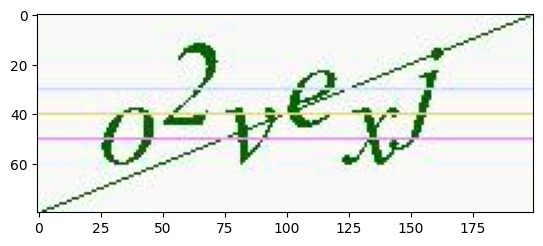

In [3]:
for i in os.listdir(PATH) :
    img = cv2.imread(PATH+i)
    print(i.split('.')[0])
    print(img.shape)
    plt.imshow(img)
    plt.show()
    break

In [4]:
Images , Labels = [], []
counter = 0
for i in os.listdir(PATH) :
    img = cv2.imread(PATH+i)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    label = i.split('.')[0]
    # print(label)
    print(f'\r {counter} - {i}',end=' ')
    
    Images.append(img)
    Labels.append(label)

    blurred = cv2.GaussianBlur(img, (7,7), 0)
    Images.append(blurred)
    Labels.append(label)

    # print(i.split('.')[0])
    # print(img.shape)
    # plt.imshow(img)
    # plt.show()
    # break
    counter += 1

Images = np.array(Images).astype('float32')/255.0
Labels = np.array(Labels)

 709 - ml5rv2.jpg 

In [5]:
print(f'\r Images shape : {Images.shape}')
print(f'\r Labels shape : {Labels.shape}')

 Images shape : (1420, 80, 200)
 Labels shape : (1420,)


In [6]:
all_chars = sorted(set(''.join(Labels)))
# all_chars.append(" ")
char_to_int = {char: i for i, char in enumerate(all_chars)}
int_to_char = {i: char for char, i in char_to_int.items()}

print(char_to_int)
print(int_to_char)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'q': 26, 'r': 27, 's': 28, 't': 29, 'u': 30, 'v': 31, 'w': 32, 'x': 33, 'y': 34, 'z': 35}
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'a', 11: 'b', 12: 'c', 13: 'd', 14: 'e', 15: 'f', 16: 'g', 17: 'h', 18: 'i', 19: 'j', 20: 'k', 21: 'l', 22: 'm', 23: 'n', 24: 'o', 25: 'p', 26: 'q', 27: 'r', 28: 's', 29: 't', 30: 'u', 31: 'v', 32: 'w', 33: 'x', 34: 'y', 35: 'z'}


In [7]:
char_to_int = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'q': 26, 'r': 27, 's': 28, 't': 29, 'u': 30, 'v': 31, 'w': 32, 'x': 33, 'y': 34, 'z': 35}
int_to_char = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'a', 11: 'b', 12: 'c', 13: 'd', 14: 'e', 15: 'f', 16: 'g', 17: 'h', 18: 'i', 19: 'j', 20: 'k', 21: 'l', 22: 'm', 23: 'n', 24: 'o', 25: 'p', 26: 'q', 27: 'r', 28: 's', 29: 't', 30: 'u', 31: 'v', 32: 'w', 33: 'x', 34: 'y', 35: 'z'}

In [8]:
# Find max length of the sequence
def max_length(labels):
    return max(len(label) for label in labels)

max_len = max_length(Labels)
print(f"Max length: {max_len}")

# Find max length of the sequence
def min_length(labels):
    return min(len(label) for label in labels)

min_len = min_length(Labels)
print(f"Min length: {min_len}")

Max length: 6
Min length: 6


In [9]:
if max_len != min_len :
    for label in Labels :
        if len(label) != 6 :
            print(label)
else :
    print('Perfect')

Perfect


In [10]:
def encode_labels(labels):
    encoded_labels = [[char_to_int[char] for char in label] for label in labels]
    return np.array(encoded_labels)

In [11]:
encoded_labels = encode_labels(Labels)

In [12]:
encoded_labels.shape

(1420, 6)

In [13]:
Labels[0],encoded_labels[0]

('o2vexj', array([24,  2, 31, 14, 33, 19]))

In [14]:
# padding sequence to max length
def pad_sequences(sequences, max_len):
    padded_sequences = np.zeros((len(sequences), max_len), dtype=np.int64)
    for i, seq in enumerate(sequences):
        padded_sequences[i][:len(seq)] = seq
    return padded_sequences

In [15]:
padded_labels = pad_sequences(encoded_labels, max_len)

# print(f"Padded labels: {padded_labels}")
print(f"Padded labels shape: {padded_labels.shape}")

Padded labels shape: (1420, 6)


In [16]:
y_encoded = torch.tensor(padded_labels)

In [17]:
# convert labels to categorical (one-hot encoding)
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

In [18]:
y_encoded = one_hot_encode(padded_labels, num_classes=len(char_to_int))
# print(f"One-hot encoded labels: {y_encoded}")

# Reshape the one-hot encoded labels
y_encoded = y_encoded.reshape(-1, max_len, len(char_to_int))
print(f"One-hot encoded labels shape: {y_encoded.shape}")

print('Label after encoding and padding :')


print(f'Label : {Labels[1]}')
print(f'Encoded label : {encoded_labels[1]}')
print(f'Padded label : {padded_labels[1]}')
print(f'One-hot encoded label : {y_encoded[1]}')

One-hot encoded labels shape: (1420, 6, 36)
Label after encoding and padding :
Label : o2vexj
Encoded label : [24  2 31 14 33 19]
Padded label : [24  2 31 14 33 19]
One-hot encoded label : [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [19]:
# split the data into train and validation

X_train, X_val, y_train, y_val = train_test_split(Images, y_encoded, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)

(1136, 80, 200) (1136, 6, 36)


In [20]:
# expand dims of X_train and X_val
X_train = np.expand_dims(X_train, axis=3)
X_val = np.expand_dims(X_val, axis=3)



# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train).permute(0, 3, 1, 2)  # Convert from HWC to CHW format
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val).permute(0, 3, 1, 2)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"X_val_tensor shape: {X_val_tensor.shape}")
print(f"y_val_tensor shape: {y_val_tensor.shape}")

# Create PyTorch DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)


X_train_tensor shape: torch.Size([1136, 1, 80, 200])
y_train_tensor shape: torch.Size([1136, 6, 36])
X_val_tensor shape: torch.Size([284, 1, 80, 200])
y_val_tensor shape: torch.Size([284, 6, 36])


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

class CNNRNNModel(nn.Module):
    def __init__(self, num_classes=36):  # Change to 63
        super(CNNRNNModel, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Fully connected layer to transform CNN output to RNN input
        self.fc1 = nn.Linear(256 * 5 * 12, 512*max_len)  # Adjust input size based on final CNN feature map size
        
        # RNN layers
        self.rnn = nn.LSTM(input_size=512, hidden_size=256, num_layers=2, batch_first=True, bidirectional=True)
        
        # Final fully connected layers
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # CNN forward pass
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        # print(x.shape)

        # Flatten the output from the CNN
        x = x.view(x.size(0), -1)
        
        # Fully connected layer
        x = self.fc1(x)

        # print(x.shape)
        
        # Reshape for RNN input (batch_size, seq_length, input_size)
        x = x.view(x.size(0), 6, 512)  # Ensure the sequence length is 6
        
        # RNN forward pass
        x, _ = self.rnn(x)
        
        # Apply fully connected layers to each time step
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.5)
        x = self.fc3(x)
        
        return x

In [29]:
def TrainModel(model, train_loader, val_loader, criterion, optimizer, scheduler, batch_size=32, num_epochs=100, patience=10, best_val_loss=float("inf") ):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Training loop
    train_losses = []
    val_losses = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            labels = labels.argmax(2).view(-1)
            out_view = outputs.view(-1, len(char_to_int))
            loss = criterion(out_view, labels)
            # loss = nn.CTCLoss(blank=62)(outputs.permute(1, 0, 2), labels, torch.full((batch_size,), 6, dtype=torch.long), torch.full((batch_size,), 6, dtype=torch.long))

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            print(f'\r {i} - {train_loss}',end='')

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(images)
                labels = labels.argmax(2).view(-1)
                loss = criterion(outputs.view(-1, len(char_to_int)), labels)
                # loss = nn.CTCLoss(blank=62)(outputs.permute(1, 0, 2), labels, torch.full((batch_size,), 6, dtype=torch.long), torch.full((batch_size,), 6, dtype=torch.long))

                val_loss += loss.item()

                print(f'\r {i} - {val_loss}',end=' ')

        # Update the learning rate
        # scheduler.step(val_loss / len(val_loader))
        scheduler.step()

        # Save the losses
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model if required
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        print(f"\rEpoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return model, train_losses, val_losses

In [33]:
model = CNNRNNModel(num_classes=len(char_to_int))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

print(model)

cuda
CNNRNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=15360, out_features=3072, bias=True)
  (rnn): LSTM(512, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_feature

In [34]:
# Train the model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

model, train_losses, val_losses = TrainModel(model, train_dataset, val_dataset, criterion, optimizer, scheduler, batch_size=32, num_epochs=100, patience=10)

Epoch 1/100, Train Loss: 3.5856, Val Loss: 3.5831
Epoch 2/100, Train Loss: 3.5806, Val Loss: 3.5820
Epoch 3/100, Train Loss: 3.5767, Val Loss: 3.5769
Epoch 4/100, Train Loss: 3.5710, Val Loss: 3.5676
Epoch 5/100, Train Loss: 3.5514, Val Loss: 3.5342
Epoch 6/100, Train Loss: 3.4650, Val Loss: 3.3930
Epoch 7/100, Train Loss: 3.2032, Val Loss: 2.9948
Epoch 8/100, Train Loss: 2.7126, Val Loss: 2.4577
Epoch 9/100, Train Loss: 2.1813, Val Loss: 2.0615
Epoch 10/100, Train Loss: 1.7343, Val Loss: 1.6351
Epoch 11/100, Train Loss: 1.3873, Val Loss: 1.3146
Epoch 12/100, Train Loss: 1.1311, Val Loss: 1.0994
Epoch 13/100, Train Loss: 0.8953, Val Loss: 0.9060
Epoch 14/100, Train Loss: 0.7231, Val Loss: 0.7509
Epoch 15/100, Train Loss: 0.5769, Val Loss: 0.5954
Epoch 16/100, Train Loss: 0.4750, Val Loss: 0.4901
Epoch 17/100, Train Loss: 0.3893, Val Loss: 0.3991
Epoch 18/100, Train Loss: 0.3162, Val Loss: 0.3432
Epoch 19/100, Train Loss: 0.2584, Val Loss: 0.2968
Epoch 20/100, Train Loss: 0.2140, Val Lo

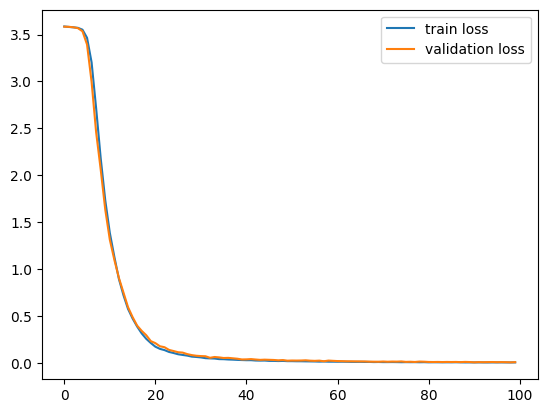

In [38]:
# plot the training and validation losses
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.show()

In [39]:
# Save the model
torch.save(model.state_dict(), 'captcha_model.pth')

Predicted text: 6zql1y


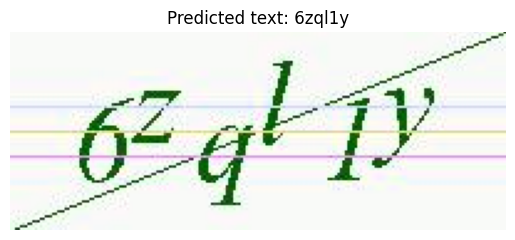

In [43]:
# test image
def FindText(img) :
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # img = cv2.resize(img, (300, 75))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    text = ''
    with torch.no_grad():
        model.eval()
        img_tensor = torch.tensor(img).unsqueeze(0).to(device)
        outputs = model(img_tensor)
        outputs = outputs.permute(1, 0, 2)
        _, preds = torch.max(outputs, 2)
        preds = preds.view(-1)
        for i in range(6):
            text += int_to_char[preds[i].item()]

    return text

img_path = 'captcha.jpg'
img = cv2.imread(img_path)
text = FindText(img)
print(f"Predicted text: {text}")
# plot with title
plt.imshow(img)
plt.title(f"Predicted text: {text}")
plt.axis('off')
plt.show()

Predicted text: p8tbc9


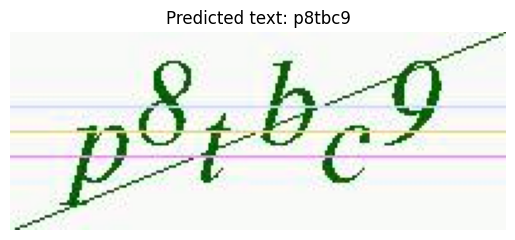

Predicted text: etzy2c


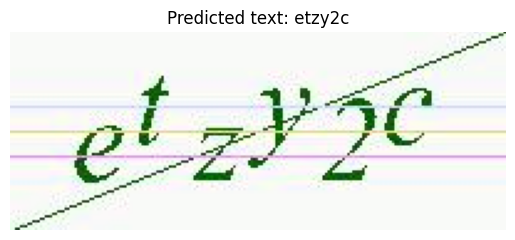

Predicted text: dbmkjc


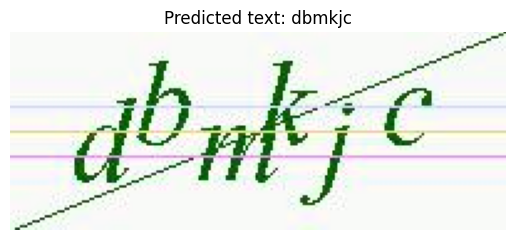

Predicted text: 9boa6o


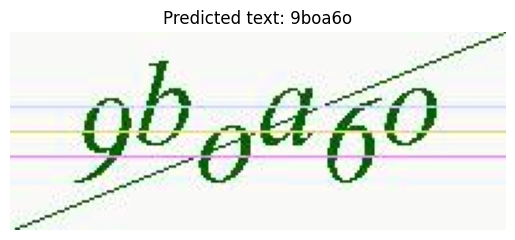

Predicted text: 4cqdx2


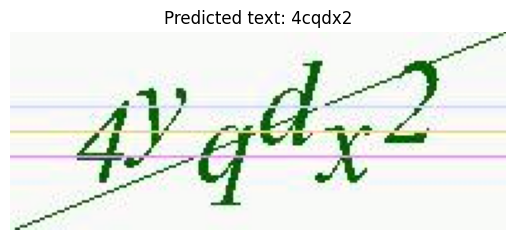

Predicted text: 5qtora


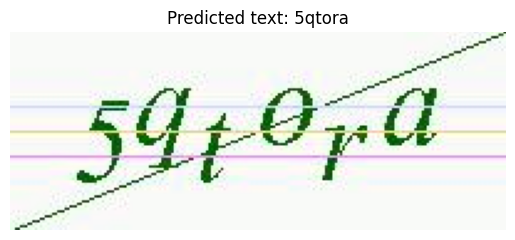

Predicted text: apcl8u


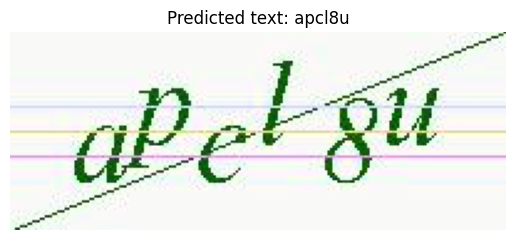

Predicted text: nd4h7v


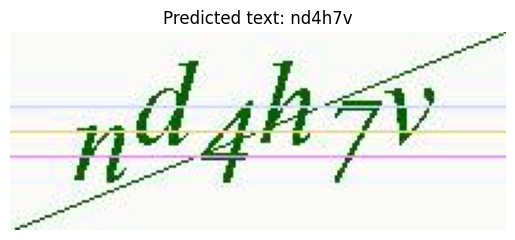

Predicted text: jpd3rk


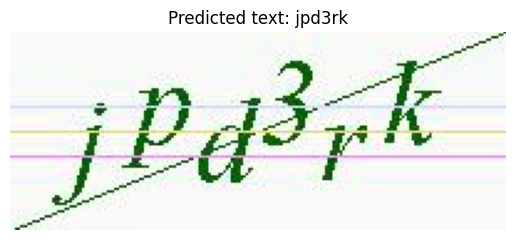

In [44]:
img_path_s = 'TestImages/'
for i in os.listdir(img_path_s) :
    img = cv2.imread(img_path_s+i)
    text = FindText(img)
    print(f"Predicted text: {text}")
    # plot with title
    plt.imshow(img)
    plt.title(f"Predicted text: {text}")
    plt.axis('off')
    plt.show()
    